## Time series KPI with Pandas

Data source: [Kaggle: Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce) and [Kaggle: Marketing Funnel by Olist](https://www.kaggle.com/olistbr/marketing-funnel-olist)

#### Project description:
Develope some ecommerce KPI functions.<br/>

#### Content
1. Data loading & preperation
2. Sales Tracker
3. KPI: Revenue Growth Rate
4. KPI: Average Order Value (AOV)
5. KPI: Purchase Frequency
6. KPI: Repeat Customer Rate

### Importing required libraries

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, NullFormatter # to remove scientific notation from axis
import warnings
warnings.filterwarnings("ignore")

In [2]:
# visualiztion settings
plt.style.use('ggplot')
sns.set(style='white')

### Data loading & preperation

NOTE: In this project, we use the data we cleaned in Data-Cleaning_mini_project.ipynb.

In [3]:
# importing dtype metadata
mapper = pd.read_csv('sales_cleaned_data_map.csv', index_col='column_name')
mapper.head()

# we change 'datetime64[ns]' to object and parse dates seperately, since pandas can't hadle them in the mapper
dt_cols = mapper.loc[mapper.data_type == 'datetime64[ns]'].index.tolist()
mapper.replace({'datetime64[ns]': 'object'}, inplace=True)

# import the cleaned file data
sales = pd.read_csv('sales_cleaned.csv', dtype=mapper.to_dict()['data_type'], parse_dates=dt_cols)

sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115931 entries, 0 to 115930
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115931 non-null  object        
 1   customer_id                    115931 non-null  object        
 2   order_status                   115931 non-null  object        
 3   order_purchase_timestamp       115931 non-null  datetime64[ns]
 4   order_approved_at              115931 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115931 non-null  datetime64[ns]
 6   order_delivered_customer_date  115931 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115931 non-null  datetime64[ns]
 8   order_item_id                  115931 non-null  uint8         
 9   product_id                     115931 non-null  object        
 10  seller_id                      115931 non-null  object        
 11  

In [4]:
# creating a df for orders
df_raw = sales.loc[:, ["order_id", "customer_unique_id", "price"]]
df_raw["order_date"] = sales.order_purchase_timestamp.dt.normalize()
df_raw = df_raw.set_index('order_date').sort_index()
df_raw.drop(pd.Timestamp('2018-09-03 00:00:00'), inplace=True)
df_raw.head()

,order_id,customer_unique_id,price
order_date,,,
2017-01-05,ec7a019261fce44180373d45b442d78f,f7b981e8a280e455ac3cbe0d5d171bd1,10.9
2017-01-05,f92641ff0446a0e1c57195ebfe76e16a,edd1864079b2d69900cbf5c2bcb931c7,9.9
2017-01-05,205d7052a6505124d200f6fea6b423bc,83e7958a94bd7f74a9414d8782f87628,9.9
2017-01-05,8a784d47854e4cbc5562362393d504db,12f5d6e1cbf93dafd9dcc19095df0b3d,9.9
2017-01-05,40599d3d28b75746952ded75566637b9,ef89f6e31311594d74becf9e18c73693,11.9


In [5]:
df_raw.shape

(115930, 3)

In [6]:
# checking memory usage by each column in MB
df_raw.memory_usage(deep=True).div(pow(1024, 2))

Index                 0.884476
order_id              9.839792
customer_unique_id    9.839792
price                 0.442238
dtype: float64

In [7]:
# grouping by price to get order total value per customer per order
df = (df_raw.groupby(["order_date", "customer_unique_id", "order_id"])[["price"]]
    .sum().reset_index().rename(columns={"price": "order_value"}).set_index("order_date", drop=True).sort_index())

df.head()

,customer_unique_id,order_id,order_value
order_date,,,
2017-01-05,12f5d6e1cbf93dafd9dcc19095df0b3d,17fed53ba6dfef9b594ee2268642e2aa,9.9
2017-01-05,12f5d6e1cbf93dafd9dcc19095df0b3d,464de32dc84484c1d26df3e8e38e708b,6.9
2017-01-05,12f5d6e1cbf93dafd9dcc19095df0b3d,747996a66f5aa711deb8ae58f5ae46a0,9.9
2017-01-05,12f5d6e1cbf93dafd9dcc19095df0b3d,8a784d47854e4cbc5562362393d504db,9.9
2017-01-05,12f5d6e1cbf93dafd9dcc19095df0b3d,9b91ddcbd6cbceb83d4fd2462ca1f95e,10.9


In [8]:
# grouping orders by day
df_daily = df.groupby(['order_date'])[['order_id', 'customer_unique_id', 'order_value']].agg(
        orders=('order_id', 'count'), customers=('customer_unique_id', 'count'), revenue=('order_value', 'sum'))
df_daily['revenue'] = df_daily['revenue'].round()

df_daily.head()

,orders,customers,revenue
order_date,,,
2017-01-05,32,32,397.0
2017-01-06,4,4,3460.0
2017-01-07,4,4,1352.0
2017-01-08,6,6,710.0
2017-01-09,5,5,674.0


### Sales Tracker

In [9]:
# a function for tracking orders and revenue
def track_sales(df, period, start_date='2017-01-05'):

    # resampling data
    df_resampled = df_daily.resample(period).sum().loc[start_date:, :]
    
    # plotting the data
    plt.figure(figsize=(13, 6), constrained_layout=True)
    ax1 = sns.barplot(x=np.arange(len(df_resampled.orders)), y=df_resampled.orders, label='number of orders', color='lightsteelblue')
    ax2 = plt.twinx()
    sns.lineplot(x=np.arange(len(df_resampled.revenue)), y=df_resampled.revenue, ax=ax2, label='revenue (R$)', color='darkred', legend=False, marker='o')
    
    ax1.set_xticklabels(df_resampled.index.strftime('%Y-%m-%d'), rotation=90)
    ax1.set_ylabel('number of orders')
    ax1.set_title(f'Orders & Revenue from {start_date} to {df_resampled.index.max().date()}', fontsize = 18)
    ax2.set_ylabel('revenue (R$)')
    
    ax1.margins(x=0)
    ax2.margins(x=0)

    # removing scientific notation from revenue axis
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2.yaxis.set_minor_formatter(NullFormatter())

    ax1.figure.legend(loc='upper left')
    plt.show()

    # return df_resampled

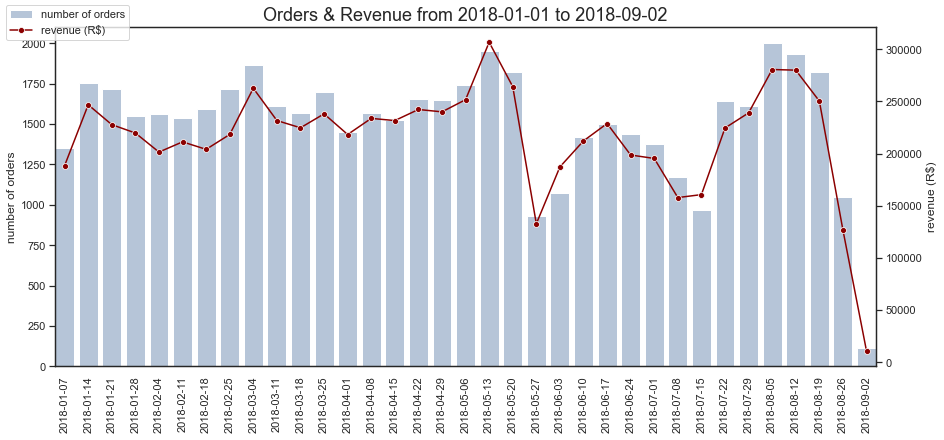

In [10]:
# tracking weekly sales from '2018-01-01'
track_sales(df, 'W', start_date='2018-01-01')

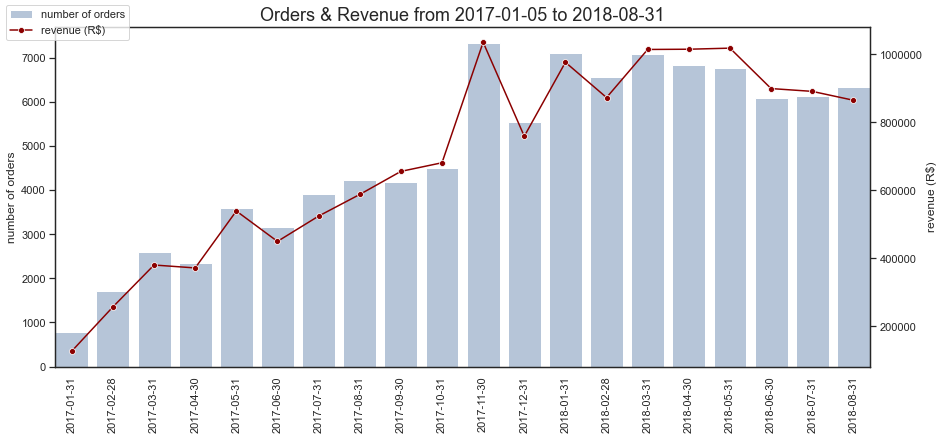

In [11]:
# tracking monthly sales
track_sales(df, 'M')

### KPI: Revenue Growth Rate

Revenue Growth Rate (%) = ( current period's revenue (\$) - previous period's revenue (\$) ) / previous period's revenue (\$) X 100

In [12]:
# Calculating revenue growth rate
def revenue_growth(df, period):

    # grouping order values by day
    revenue_df = df.groupby(['order_date'])[['order_value']].sum().rename(columns={'order_value': 'revenue'})

    # calculating growth rate
    rev_growth = revenue_df.resample(period).sum().pct_change(periods=1).mul(100).rename(columns={'revenue': 'revenue_growth_percent'})
    rev_growth.index.name = 'date'
    
    # plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['cornflowerblue' if x>0 else 'darksalmon' for x in rev_growth.revenue_growth_percent]
    sns.barplot(x=np.arange(len(rev_growth)), y=rev_growth.revenue_growth_percent, palette=colors)
    ax.set_xticklabels(rev_growth.index.strftime('%Y-%m-%d'), rotation=90)

    # sns.color_palette("coolwarm", as_cmap=True)
    for i, v in enumerate(rev_growth.revenue_growth_percent.fillna(0)):
        plt.text(i, v+2, f'{str(round(v))}%', horizontalalignment='center')

    # pal = sns.color_palette("Greens_d", len(rev_growth))
    ax.set_ylabel('revenue growth rate (%)')
    ax.set_title('Revenue Growth Rate', fontsize = 18)

    plt.tight_layout()
    plt.show()

    # return rev_growth


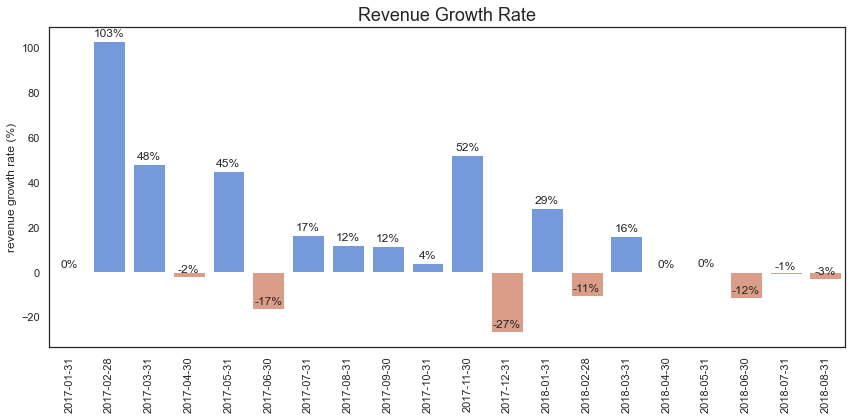

In [13]:
# monthly revenue growth
revenue_growth(df, 'M')

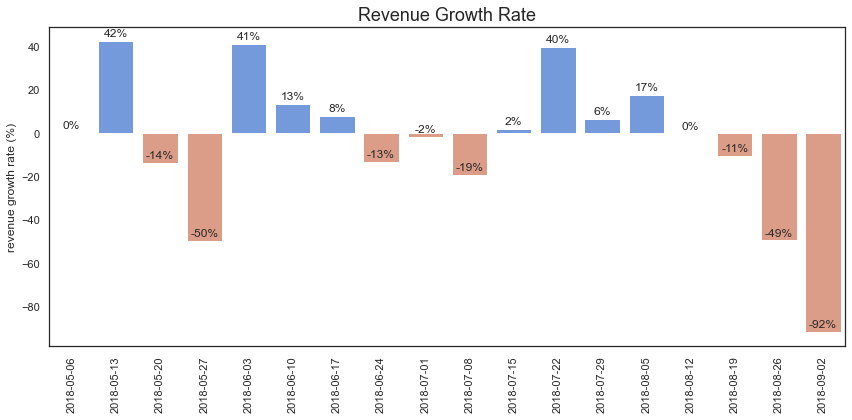

In [14]:
# weekly revenue growth from 2018-05
revenue_growth(df.loc['2018-05':'2018-08'], 'W')

### KPI: Average Order Value (AOV)

Average Order Value (\$) = total revenue (\$) / orders placed (#)

In [15]:
# creating a function to track moving AOV

def moving_aov(df, window_in_days):

    # grouping orders and revenue by day
    daily_orders = df.groupby(['order_date'])[['order_id', 'order_value']].agg(orders=('order_id', 'count'), revenue=('order_value', 'sum')).sort_index()
    daily_orders.revenue = round(daily_orders.revenue)

    # calculating moving orders and revenue within specified window
    daily_orders[['rolling_orders', 'rolling_revenue']] = daily_orders.rolling(window_in_days).sum()
    daily_orders['rolling_aov'] = round(daily_orders.rolling_revenue.div(daily_orders.rolling_orders))

    # Calculating statistics
    mean, median, std, min, max = daily_orders.rolling_aov.agg(['mean', 'median', 'std', 'min', 'max']).round()
    mode = daily_orders.rolling_aov.round().mode()[0]
    last_aov = daily_orders.loc[daily_orders.index.max(), 'rolling_aov'].round()

    print(f'Last {window_in_days} days Moving AOV: R$ {last_aov}\n')

    for i, v in [('Mode', mode), ('Median', median), ('Mean', mean), ('STD', std), ('Min', min), ('Max', max)]:
        print(f'{window_in_days}-day Moving AOV {i}: R$ {v}')

    # plotting the data
    fig, axs = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True)
    axs[0].plot(daily_orders.index, daily_orders.rolling_aov)
    axs[0].set(ylabel='AOV (R$)', title=f'{window_in_days}-day Average Order Value (AOV)')

    sns.histplot(daily_orders.rolling_aov, ax=axs[1], kde=True)
    axs[1].set(xlabel='Moving AOV', ylabel='AOV Frequency', title=f'{window_in_days}-day Average Order Value (AOV) distribution')

    sns.boxenplot(daily_orders.rolling_aov, ax=axs[2])
    axs[2].set(xlabel='Moving AOV', title=f'{window_in_days}-day Average Order Value (AOV) distribution by quantiles')

    plt.margins(x=0)
    plt.show()
    
    # return daily_orders

Last 30 days Moving AOV: R$ 137.0

30-day Moving AOV Mode: R$ 148.0
30-day Moving AOV Median: R$ 147.0
30-day Moving AOV Mean: R$ 145.0
30-day Moving AOV STD: R$ 8.0
30-day Moving AOV Min: R$ 131.0
30-day Moving AOV Max: R$ 169.0


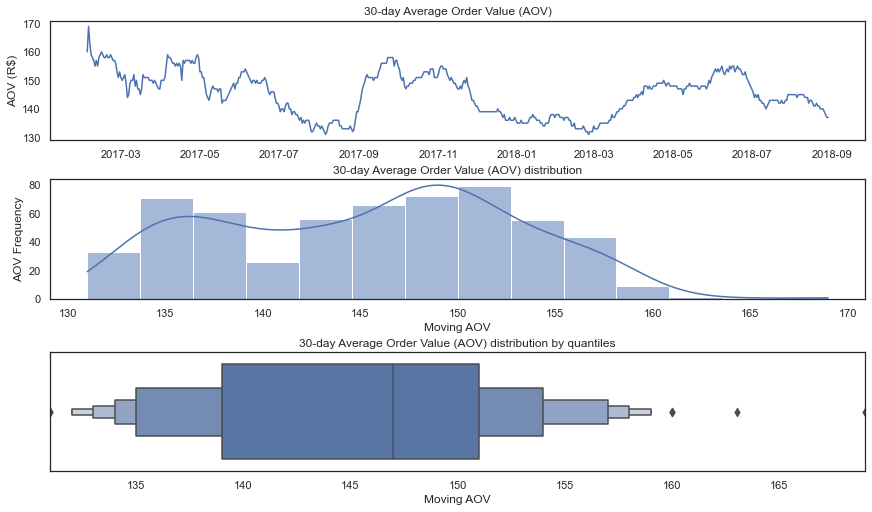

In [16]:
# monthly AOV
# NOTE: a high value order was placed in 2017-01-06
moving_aov(df, 30)

Last 7 days Moving AOV: R$ 115.0

7-day Moving AOV Mode: R$ 138.0
7-day Moving AOV Median: R$ 142.0
7-day Moving AOV Mean: R$ 142.0
7-day Moving AOV STD: R$ 10.0
7-day Moving AOV Min: R$ 113.0
7-day Moving AOV Max: R$ 166.0


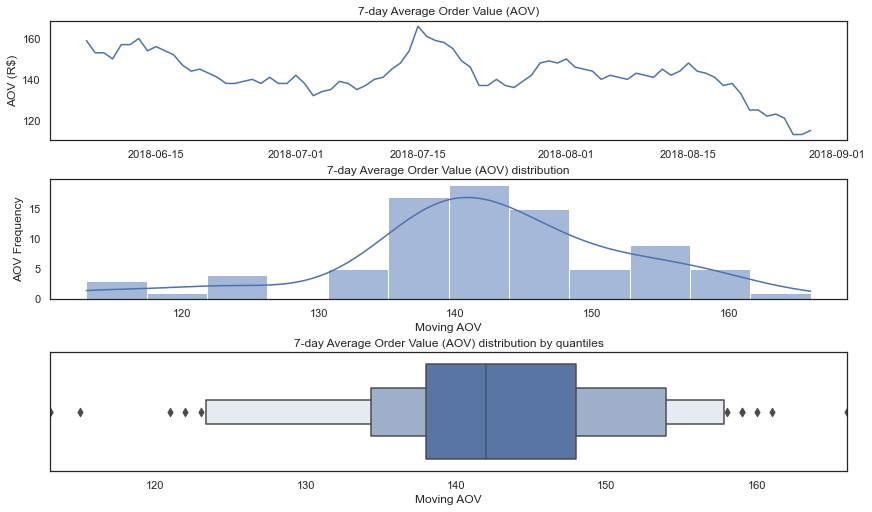

In [17]:
# weekly AOV for the last 90 days of the dataset
moving_aov(df.loc[pd.date_range(end=df.index.max(), periods=90)], 7)

### KPI: Purchase Frequency

Purchase Frequency = No. orders / No. unique customers

In [18]:
# Tracking average number of orders placed by customers

def purchase_frequency(df):

    # Average number of orders placed by each customer in the dataset's timeframe
    avg_purch_freq = round(df.order_id.nunique()/df.customer_unique_id.nunique(), 2)
    print(f'Average purchase frequency: {avg_purch_freq}\n')

    # calculating frequency & relative frequency for the number of customers' orders
    purch_freq = df.groupby('customer_unique_id')['order_id'].count().value_counts().to_frame().reset_index().rename(columns={'order_id': 'customers', 'index': 'purchase_freq'}).set_index('purchase_freq', drop=True)
    purch_freq['percent'] = (purch_freq.customers/purch_freq.customers.sum()).mul(100).round(3)
    
    # percentage of customers that placed more than 1 order
    more_than_one_order = purch_freq.loc[purch_freq.index > 1, 'percent'].sum().round(2)
    print(f'Percentage of customers with purchase frequency above 1: {more_than_one_order}%\n')

    # plotting the purchase frequency by number of orders per customer
    fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
    ax.step(purch_freq.index, purch_freq.customers.cumsum())

    ax.annotate(f'Average Purchase Frequency = {avg_purch_freq}', xy=(4, 93000), fontsize=15, color='red')
    ax.annotate(f'{more_than_one_order}% of customers purchased more than once', xy=(4, 92800), fontsize=15, color='red')
   
    ax.set(xlabel='average purchase frequency', ylabel='number of customers')
    ax.set_title('No of orders per unique customer', fontsize=18)

    ax.set_xticks(np.arange(purch_freq.index.max()+1), labels=np.arange(purch_freq.index.max()+1))
    plt.show()

    return purch_freq.sort_index()

Average purchase frequency: 1.03

Percentage of customers with purchase frequency above 1: 3.0%



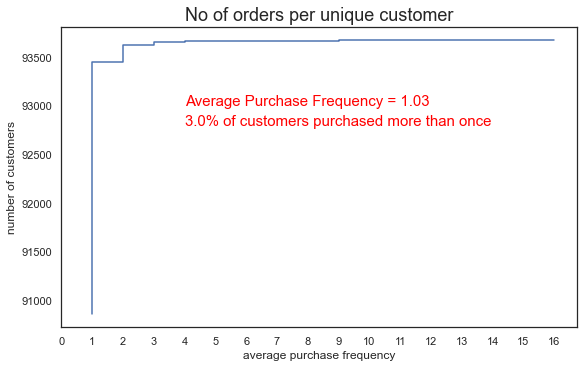

,customers,percent
purchase_freq,,
1,90866,97.002
2,2582,2.756
3,179,0.191
4,28,0.030
5,9,0.010
6,5,0.005
7,3,0.003
9,1,0.001
16,1,0.001


In [19]:
# purchase frequency for the whole dataset
purchase_frequency(df)

Average purchase frequency: 1.01

Percentage of customers with purchase frequency above 1: 1.1%



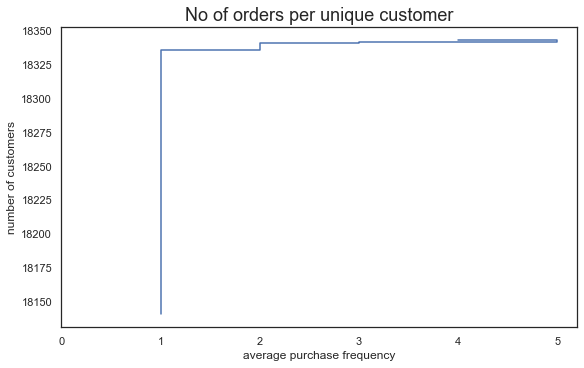

,customers,percent
purchase_freq,,
1,18141,98.899
2,195,1.063
3,5,0.027
4,1,0.005
5,1,0.005


In [20]:
# purchase frequency for the last 90 days of the dataset
purchase_frequency(df.loc[pd.date_range(end=df.index.max(), periods=90)])

### KPI: Repeat Customer Rate

Repeat Customer Rate (%) = (No. customers who've purchased before / Total no. customers) × 100

definitions: 
- number of customers who've purchased before & returned another day and placed orders<br/>
- repeat frequency is the count of days the customer had a purchase on<br/>
- unit of repeat_days_freq is the number of days a custumer returned

In [21]:
# Shows percentage of customers return to shop again

def repeat_customer_rate(df):
    
    # grouping orders by date for each customer
    customer_orders = df.groupby(['customer_unique_id', 'order_date'])[['order_id', 'order_value']].agg(orders=('order_id', 'count'), revenue=('order_value', 'sum')).reset_index()
    customer_orders['revenue'] = round(customer_orders.revenue)

    # finding customers placed orders in more than one day
    repeat_customers = customer_orders.loc[customer_orders.duplicated(subset=['customer_unique_id'], keep=False)]
    
    # creating a returning customers dataframe to join with customer_orders
    merging_df = repeat_customers[['customer_unique_id', 'order_date']]
    merging_df['repeat_customer'] = 1

    # Adding a column flagging returning customers by a join
    repeat_df = pd.merge(customer_orders, merging_df, on=['customer_unique_id', 'order_date'], how='left')
    repeat_df.repeat_customer.fillna(0, inplace=True)

    # grouping customers by number of times they returned & create a frequency table
    repeat_freq = repeat_df.groupby('customer_unique_id')['repeat_customer'].sum().value_counts().to_frame()
    repeat_freq.rename(columns={'repeat_customer': 'customers'}, index={0: 1}, inplace=True)
    repeat_freq.index.name= 'repeat_freq'
    repeat_freq.index = repeat_freq.index.astype('int')
    repeat_freq['percent'] = repeat_freq.customers.div(repeat_freq.customers.sum()).mul(100).round(3)

    # Customer repeat rate for the dataset
    avg_repeat_rate = round(repeat_customers.customer_unique_id.nunique() / df.customer_unique_id.nunique() * 100, 2)
    avg_repeat_customer_rate = f'Average Customer Repeat Rate: {avg_repeat_rate}%'
    print(avg_repeat_customer_rate)

    # plotting Customer repeat rate
    fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
    ax.step(repeat_freq.index, repeat_freq.customers.cumsum())

    ax.annotate(avg_repeat_customer_rate, xy=(4, 93000), fontsize=15, color='red')
   
    ax.set(xlabel='average repeat purchase frequency', ylabel='number of customers')
    ax.set_title('Repeat Cutomer Rate', fontsize=18)

    ax.set_xticks(np.arange(repeat_freq.index.max()+1), labels=np.arange(repeat_freq.index.max()+1))
    plt.show()


    return repeat_freq

Average Customer Repeat Rate: 2.14%


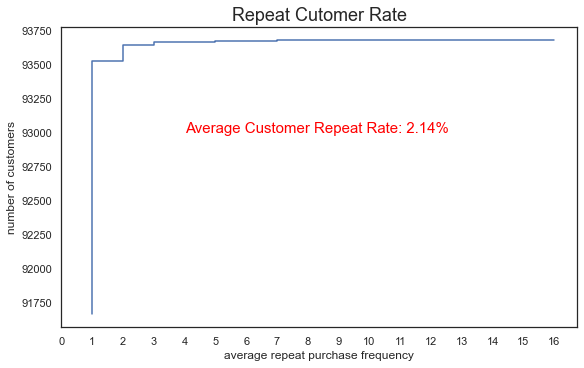

,customers,percent
repeat_freq,,
1,91669,97.860
2,1855,1.980
3,119,0.127
4,17,0.018
5,6,0.006
6,5,0.005
7,2,0.002
16,1,0.001


In [22]:
# repeat customer rate for the whole dataset
repeat_customer_rate(df)

Average Customer Repeat Rate: 0.75%


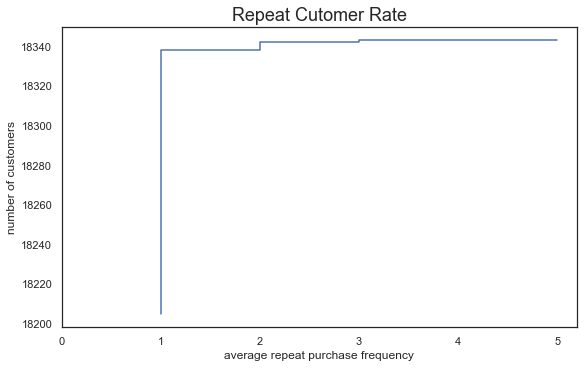

,customers,percent
repeat_freq,,
1,18205,99.248
2,133,0.725
3,4,0.022
5,1,0.005


In [23]:
# repeat customer rate for the last 90 days of the dataset
last_90_days = pd.date_range(end=df.index.max(), periods=90)
repeat_customer_rate(df.loc[last_90_days])